In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/NSCLC-Radiomics.zip" -d "/content/NSCLC"

Streaming output truncated to the last 5000 lines.
  inflating: /content/NSCLC/NSCLC-Radiomics/LUNG1-385/03-27-2010-NA-NA-88787/0.000000-NA-40259/1-063.dcm  
  inflating: /content/NSCLC/NSCLC-Radiomics/LUNG1-385/03-27-2010-NA-NA-88787/0.000000-NA-40259/1-064.dcm  
  inflating: /content/NSCLC/NSCLC-Radiomics/LUNG1-385/03-27-2010-NA-NA-88787/0.000000-NA-40259/1-065.dcm  
  inflating: /content/NSCLC/NSCLC-Radiomics/LUNG1-385/03-27-2010-NA-NA-88787/0.000000-NA-40259/1-066.dcm  
  inflating: /content/NSCLC/NSCLC-Radiomics/LUNG1-385/03-27-2010-NA-NA-88787/0.000000-NA-40259/1-067.dcm  
  inflating: /content/NSCLC/NSCLC-Radiomics/LUNG1-385/03-27-2010-NA-NA-88787/0.000000-NA-40259/1-068.dcm  
  inflating: /content/NSCLC/NSCLC-Radiomics/LUNG1-385/03-27-2010-NA-NA-88787/0.000000-NA-40259/1-069.dcm  
  inflating: /content/NSCLC/NSCLC-Radiomics/LUNG1-385/03-27-2010-NA-NA-88787/0.000000-NA-40259/1-070.dcm  
  inflating: /content/NSCLC/NSCLC-Radiomics/LUNG1-385/03-27-2010-NA-NA-88787/0.000000-NA-4025

In [ ]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 12.2 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import SimpleITK as sitk
import cv2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


ModuleNotFoundError: No module named 'SimpleITK'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import copy

# define data transformations
transform = transforms.Compose([
    transforms.Resize((250, 250)),  # resize images to 250x250 pixels
    transforms.ToTensor(),  # convert images to pytorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize images with mean and std deviation of imagenet dataset
])

# specify the directory containing the dataset
data_dir = 'Processed_Data'

# load the datasets with the specified transformations
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)  # load training dataset with transformations
valid_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transform=transform)  # load validation dataset with transformations
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)  # load test dataset with transformations

# set batch size for the dataloaders
batch_size = 32  # number of images to be processed in one iteration


# print dataset sizes for confirmation
print(f"Number of training images: {len(train_dataset)}") # 600
print(f"Number of validation images: {len(valid_dataset)}") # 72
print(f"Number of test images: {len(test_dataset)}") # 315

In [ ]:

csv_path = "/content/NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv"
df = pd.read_csv(csv_path)

base_dir = "/content/NSCLC"

def find_files(patient_id):
    folder_path = os.path.join(base_dir, patient_id)
    if not os.path.exists(folder_path):
        return None, None
    files = os.listdir(folder_path)
    image = next((os.path.join(folder_path, f) for f in files if 'image' in f.lower()), None)
    mask = next((os.path.join(folder_path, f) for f in files if 'mask' in f.lower()), None)
    return image, mask

df["image_path"], df["mask_path"] = zip(*df["PatientID"].apply(find_files))

df.dropna(subset=["image_path", "mask_path"], inplace=True)


In [ ]:
some_folder = os.listdir(base_dir)[0]
print(f"Contents of /content/NSCLC/{some_folder}:")
print(os.listdir(os.path.join(base_dir, some_folder)))


Contents of /content/NSCLC/NSCLC-Radiomics:
['LUNG1-058', 'LUNG1-234', 'LUNG1-176', 'LUNG1-201', 'LUNG1-391', 'LUNG1-312', 'LUNG1-237', 'LUNG1-142', 'LUNG1-277', 'LUNG1-109', 'LUNG1-003', 'LUNG1-353', 'LUNG1-231', 'LUNG1-123', 'LUNG1-345', 'LUNG1-310', 'LUNG1-077', 'LUNG1-071', 'LUNG1-341', 'LUNG1-401', 'LUNG1-278', 'LUNG1-097', 'LUNG1-389', 'LUNG1-279', 'LUNG1-403', 'LUNG1-066', 'LUNG1-190', 'LUNG1-414', 'LUNG1-405', 'LUNG1-030', 'LUNG1-274', 'LUNG1-307', 'LUNG1-314', 'LUNG1-324', 'LUNG1-141', 'LUNG1-270', 'LUNG1-349', 'LUNG1-257', 'LUNG1-166', 'LUNG1-131', 'LUNG1-179', 'LUNG1-157', 'LUNG1-239', 'LUNG1-038', 'LUNG1-356', 'LUNG1-204', 'LUNG1-238', 'LUNG1-294', 'LUNG1-371', 'LUNG1-236', 'LUNG1-384', 'LUNG1-363', 'LUNG1-256', 'LUNG1-203', 'LUNG1-223', 'LUNG1-240', 'LUNG1-214', 'LUNG1-385', 'LUNG1-197', 'LUNG1-006', 'LUNG1-032', 'LUNG1-361', 'LUNG1-120', 'LUNG1-291', 'LUNG1-398', 'LUNG1-369', 'LUNG1-161', 'LUNG1-128', 'LUNG1-209', 'LUNG1-285', 'LUNG1-067', 'LUNG1-418', 'LUNG1-338', 'LUNG1

In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.1 MB/s eta 0:00:00


In [ ]:
import os


base_folder = '/content/NSCLC/NSCLC-Radiomics'
for patient_folder in os.listdir(base_folder):
    folder_path = os.path.join(base_folder, patient_folder)

    if os.path.isdir(folder_path):
        print(f"Found patient folder: {patient_folder}")

        for root, dirs, files in os.walk(folder_path):
            print(f"Checking {root}...")
            for file in files:
                print(f"Found file: {file}")
                if file.endswith('.dcm'):
                    print(f"Found DICOM file: {file}")
                else:
                    print(f"Not a DICOM file: {file}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Found DICOM file: 1-089.dcm
Found file: 1-030.dcm
Found DICOM file: 1-030.dcm
Found file: 1-132.dcm
Found DICOM file: 1-132.dcm
Found file: 1-080.dcm
Found DICOM file: 1-080.dcm
Found file: 1-141.dcm
Found DICOM file: 1-141.dcm
Found file: 1-097.dcm
Found DICOM file: 1-097.dcm
Found file: 1-076.dcm
Found DICOM file: 1-076.dcm
Found file: 1-136.dcm
Found DICOM file: 1-136.dcm
Found file: 1-075.dcm
Found DICOM file: 1-075.dcm
Found file: 1-127.dcm
Found DICOM file: 1-127.dcm
Found file: 1-014.dcm
Found DICOM file: 1-014.dcm
Found file: 1-056.dcm
Found DICOM file: 1-056.dcm
Found file: 1-003.dcm
Found DICOM file: 1-003.dcm
Found file: 1-060.dcm
Found DICOM file: 1-060.dcm
Found file: 1-083.dcm
Found DICOM file: 1-083.dcm
Found file: 1-044.dcm
Found DICOM file: 1-044.dcm
Found file: 1-072.dcm
Found DICOM file: 1-072.dcm
Found file: 1-010.dcm
Found DICOM file: 1-010.dcm
Found file: 1-123.dcm
Found DICOM file: 1-12

In [ ]:
import pydicom
import numpy as np
import os
from collections import Counter

def load_dicom_volume(folder_path):
    slices = []

    for root, dirs, files in os.walk(folder_path):
        for f in files:
            if f.endswith('.dcm'):
                path = os.path.join(root, f)
                try:
                    ds = pydicom.dcmread(path)

                    if 'PixelData' not in ds:
                        continue

                    instance = getattr(ds, 'InstanceNumber', None)
                    shape = ds.pixel_array.shape
                    if instance is not None:
                        slices.append((instance, ds, shape))

                except Exception as e:
                    print(f"❌ Error reading {f}: {e}")
                    continue

    if len(slices) == 0:
        print("⚠️ No valid slices found.")
        return None

    # Keep only slices with the most common shape
    shape_counts = Counter([s[2] for s in slices])
    most_common_shape = shape_counts.most_common(1)[0][0]

    filtered_slices = [(i, ds) for (i, ds, shape) in slices if shape == most_common_shape]
    filtered_slices.sort(key=lambda x: x[0])  # sort by instance

    if len(filtered_slices) < 3:
        print("⚠️ Too few consistent slices.")
        return None

    volume = np.stack([ds.pixel_array for _, ds in filtered_slices])
    return volume


✅ Volume shape: (134, 512, 512)


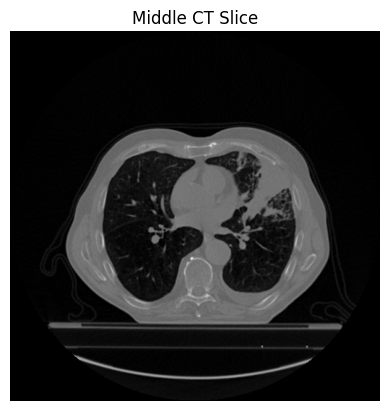

In [ ]:
sample_patient = '/content/NSCLC/NSCLC-Radiomics/LUNG1-001'
volume = load_dicom_volume(sample_patient)

if volume is not None:
    print(f"✅ Volume shape: {volume.shape}")
    import matplotlib.pyplot as plt
    mid = volume.shape[0] // 2
    plt.imshow(volume[mid], cmap='gray')
    plt.axis('off')
    plt.title("Middle CT Slice")
    plt.show()
else:
    print("❌ Failed to load volume.")

In [ ]:
import os
import pydicom
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
from collections import Counter

# ==== Paths ====
base_path = '/content/NSCLC/NSCLC-Radiomics'
label_csv_path = '/content/radiomics_new.csv'
save_path = '/content/slices_resnet'
os.makedirs(save_path, exist_ok=True)

# ==== Load Labels CSV ====
df_labels = pd.read_csv(label_csv_path)
df_labels['PatientID'] = df_labels['PatientID'].astype(str).str.strip()

# Keep only rows with both ID and Histology
df_labels = df_labels[df_labels['label'].notnull() & df_labels['PatientID'].notnull()]
label_dict = dict(zip(df_labels['PatientID'], df_labels['label']))

# ==== Helper: Load valid volume with consistent shape ====
def load_dicom_volume(folder_path):
    slices = []

    for root, dirs, files in os.walk(folder_path):
        for f in files:
            if f.endswith('.dcm'):
                path = os.path.join(root, f)
                try:
                    ds = pydicom.dcmread(path)
                    if 'PixelData' not in ds:
                        continue

                    instance = getattr(ds, 'InstanceNumber', None)
                    shape = ds.pixel_array.shape
                    if instance is not None:
                        slices.append((instance, ds, shape))

                except Exception as e:
                    print(f"❌ Error reading {f}: {e}")
                    continue

    if len(slices) == 0:
        return None

    # Use only slices with the most common shape
    shape_counts = Counter([s[2] for s in slices])
    most_common_shape = shape_counts.most_common(1)[0][0]
    filtered_slices = [(i, ds) for (i, ds, shape) in slices if shape == most_common_shape]
    filtered_slices.sort(key=lambda x: x[0])

    if len(filtered_slices) < 3:
        return None

    volume = np.stack([ds.pixel_array for _, ds in filtered_slices])
    return volume

# ==== Extract middle slice, resize, normalize ====
def extract_middle_slice(volume):
    try:
        if volume.ndim != 3 or volume.shape[0] == 0:
            return None

        mid = volume.shape[0] // 2
        slice_img = volume[mid]

        if slice_img is None or slice_img.size == 0:
            return None

        slice_img = cv2.resize(slice_img, (224, 224))
        slice_img = cv2.normalize(slice_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        return slice_img

    except Exception as e:
        print(f"❌ Error processing slice: {e}")
        return None

# ==== Main Loop ====
records = []
skipped = []

for patient_id in tqdm(label_dict.keys()):
    patient_path = os.path.join(base_path, patient_id)

    if not os.path.exists(patient_path):
        skipped.append((patient_id, "Missing folder"))
        continue

    volume = load_dicom_volume(patient_path)
    if volume is None:
        print(f"⚠️ Skipping {patient_id}: Invalid or inconsistent volume")
        skipped.append((patient_id, "Invalid volume"))
        continue

    slice_img = extract_middle_slice(volume)
    if slice_img is None:
        print(f"Skipping {patient_id}: Invalid slice")
        skipped.append((patient_id, "Invalid slice"))
        continue

    try:
        filename = f"{patient_id}.png"
        cv2.imwrite(os.path.join(save_path, filename), slice_img)
        records.append({
            'image': filename,
            'label': label_dict[patient_id]
        })
    except Exception as e:
        print(f"Error saving {patient_id}: {e}")
        skipped.append((patient_id, "Save failed"))

# ==== Save Image-Label CSV ====
df_out = pd.DataFrame(records)
df_out.to_csv('/content/resnet_image_labels.csv', index=False)

print(f"\nSaved {len(records)} images.")
print(f"Skipped {len(skipped)} patients.")

# Optional: Save skipped log
pd.DataFrame(skipped, columns=["PatientID", "Reason"]).to_csv('/content/skipped_patients.csv', index=False)


100%|██████████| 187/187 [04:18<00:00,  1.38s/it]


Saved 187 images.
Skipped 0 patients.


In [ ]:
import os
import pandas as pd

# === CONFIG ===
csv_path = "/content/resnet_image_labels.csv"
image_dir = "/content/slices_resnet"

# === Load CSV ===
df = pd.read_csv(csv_path)

# Ensure it has an 'image' column
assert 'image' in df.columns, "'image' column not found in the CSV"

# === Create set of valid image filenames from CSV ===
valid_images = set(df['image'])

# === Delete excess images ===
deleted_count = 0
for img_file in os.listdir(image_dir):
    if img_file not in valid_images:
        os.remove(os.path.join(image_dir, img_file))
        deleted_count += 1

print(f"✅ Done. Deleted {deleted_count} images not listed in the CSV.")


✅ Done. Deleted 193 images not listed in the CSV.


In [ ]:
import pandas as pd

# Load the image-labels CSV that contains the valid PatientIDs
img_df = pd.read_csv("/content/resnet_image_labels.csv")

# Make sure PatientID exists (extract if necessary)
if "PatientID" not in img_df.columns:
    img_df["PatientID"] = img_df["image"].str.extract(r"(LUNG1-\d+)", expand=False)

# Get list of valid PatientIDs
valid_pids = set(img_df["PatientID"])

# Load the radiomics features CSV
rad_df = pd.read_csv("/content/radiomics_features.csv")

# Keep only the radiomics rows that match the ResNet image patients
filtered_rad_df = rad_df[rad_df["PatientID"].isin(valid_pids)].reset_index(drop=True)

# Save the cleaned version
filtered_rad_df.to_csv("/content/radiomics_novo.csv", index=False)


In [ ]:
!pip install pyradiomics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 18.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739

In [ ]:
import os
from pathlib import Path
from pydicom import dcmread

folder = Path('/content/NSCLC/NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID-NA-69331/0.000000-NA-82046')

for f in folder.glob("*.dcm"):
    try:
        ds = dcmread(str(f))
        print(f"{f.name}: Modality={ds.Modality}, SeriesUID={ds.SeriesInstanceUID}")
    except:
        print(f"⚠️ {f.name} is not a valid DICOM")


1-084.dcm: Modality=CT, SeriesUID=1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046
1-098.dcm: Modality=CT, SeriesUID=1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046
1-073.dcm: Modality=CT, SeriesUID=1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046
1-042.dcm: Modality=CT, SeriesUID=1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046
1-040.dcm: Modality=CT, SeriesUID=1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046
1-088.dcm: Modality=CT, SeriesUID=1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046
1-131.dcm: Modality=CT, SeriesUID=1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046
1-058.dcm: Modality=CT, SeriesUID=1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046
1-105.dcm: Modality=CT, SeriesUID=1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046
1-114.dcm: Modality=CT, SeriesUID=1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046
1-081.dcm: Modality=

In [ ]:
df.columns.tolist()

['image',
 'label',
 'label_encoded',
 'PatientID',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_27',
 'feature_28',
 'feature_29',
 'feature_30']

In [ ]:
# Install deps
!pip install -q timm imbalanced-learn lightgbm torchvision tqdm

import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

# Hyperparameters
NUM_FOLDS = 5
EPOCHS = 20
BATCH_SIZE = 16
IMG_DIR = "/content/slices_resnet"
CSV_PATH = "/content/resnet_image_labels.csv"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MIXUP_ALPHA = 0.4

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None):
        super().__init__()
        self.gamma = gamma
        # ENSURE weight is float32
        if weight is not None:
            weight = weight.to(torch.float32)
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, logits, targets):
        logp = -self.ce(logits, targets)   # log-probabilities
        p = torch.exp(logp)
        loss = -((1 - p) ** self.gamma) * logp
        return loss.mean()

# MixUp (λ as Python float)
def mixup(x, y, alpha=MIXUP_ALPHA):
    lam = float(np.random.beta(alpha, alpha))
    idx = torch.randperm(x.size(0))
    mixed = lam * x + (1 - lam) * x[idx]
    return mixed, y, y[idx], lam

# Transforms (RandomErasing after Normalize)
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.3,0.3,0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    transforms.RandomErasing(p=0.2)
])
valid_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
tta_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Load labels
df = pd.read_csv(CSV_PATH)
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Stratified KFold
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
all_preds = [None] * len(df)

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['label_encoded']), 1):
    print(f"\n=== Fold {fold}/{NUM_FOLDS} ===")
    df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]

    # Dataset & Loader
    class DS(torch.utils.data.Dataset):
        def __init__(self, df, tf):
            self.df, self.tf = df.reset_index(drop=True), tf
        def __len__(self): return len(self.df)
        def __getitem__(self, i):
            row = self.df.iloc[i]
            img = Image.open(os.path.join(IMG_DIR, row.image)).convert("RGB")
            return self.tf(img), row.label_encoded

    train_loader = torch.utils.data.DataLoader(DS(df_train, train_tf),
                                               batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader   = torch.utils.data.DataLoader(DS(df_val,   valid_tf),
                                               batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # Model
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, len(le.classes_))
    model.to(DEVICE)

    # Class weights (float32!)
    inv_counts = 1.0 / df_train['label_encoded'].value_counts(sort=False).sort_index().values
    weight_tensor = torch.tensor(inv_counts, device=DEVICE, dtype=torch.float32)
    crit = FocalLoss(weight=weight_tensor)

    opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    sched = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                steps_per_epoch=len(train_loader), epochs=EPOCHS)

    best_acc = 0
    for ep in range(1, EPOCHS+1):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            x_mix, ya, yb, lam = mixup(x, y)
            opt.zero_grad()
            logits = model(x_mix)
            loss = lam * crit(logits, ya) + (1 - lam) * crit(logits, yb)
            loss.backward()
            opt.step()
            sched.step()
            running_loss += loss.item()
        print(f"Epoch {ep} train loss: {running_loss/len(train_loader):.4f}")

        # Validation
        model.eval()
        preds, truths = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                out = model(x).argmax(1).cpu().tolist()
                preds += out; truths += y.cpu().tolist()
        acc = accuracy_score(truths, preds)
        print(f"Epoch {ep} val  acc : {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), f"/content/resnet_fold{fold}.pth")

    # TTA on val set
    model.load_state_dict(torch.load(f"/content/resnet_fold{fold}.pth"))
    tta_preds = []
    imgs = df_val['image'].tolist()
    for _ in range(4):
        batch = torch.stack([tta_tf(Image.open(os.path.join(IMG_DIR, f)).convert("RGB"))
                             for f in imgs], dim=0).to(DEVICE)
        with torch.no_grad():
            tta_preds.append(torch.softmax(model(batch),1).cpu().numpy())
    avg = np.mean(tta_preds,0).argmax(1).tolist()
    for i, p in zip(val_idx, avg):
        all_preds[i] = p

# Final ensemble accuracy
y_true = df['label_encoded'].tolist()
acc = accuracy_score(y_true, all_preds)
print(f"\n⇒ Ensembling CV Accuracy: {acc*100:.2f}%")
cm = confusion_matrix(y_true, all_preds)
Disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
Disp.plot(cmap='Blues', xticks_rotation=45)
plt.show()


=== Fold 1/5 ===
Epoch 1 train loss: 0.9562
Epoch 1 val  acc : 0.2632
Epoch 2 train loss: 0.8111
Epoch 2 val  acc : 0.2895
Epoch 3 train loss: 0.8021
Epoch 3 val  acc : 0.2632
Epoch 4 train loss: 0.8721
Epoch 4 val  acc : 0.2632
Epoch 5 train loss: 0.8774
Epoch 5 val  acc : 0.2368
Epoch 6 train loss: 0.7703
Epoch 6 val  acc : 0.2368
Epoch 7 train loss: 0.7066
Epoch 7 val  acc : 0.2105
Epoch 8 train loss: 0.9190
Epoch 8 val  acc : 0.2368
Epoch 9 train loss: 0.7432
Epoch 9 val  acc : 0.2632
Epoch 10 train loss: 0.6975
Epoch 10 val  acc : 0.3421
Epoch 11 train loss: 0.6034
Epoch 11 val  acc : 0.2632
Epoch 12 train loss: 0.6090
Epoch 12 val  acc : 0.2895
Epoch 13 train loss: 0.4456
Epoch 13 val  acc : 0.2368
Epoch 14 train loss: 0.3599
Epoch 14 val  acc : 0.1842
Epoch 15 train loss: 0.4500
Epoch 15 val  acc : 0.2105
Epoch 16 train loss: 0.3419
Epoch 16 val  acc : 0.2632
Epoch 17 train loss: 0.3103
Epoch 17 val  acc : 0.1842
Epoch 18 train loss: 0.3401
Epoch 18 val  acc : 0.1842
Epoch 19 t

In [ ]:
import os
import pandas as pd
import SimpleITK as sitk
import pydicom
from radiomics import featureextractor
from tqdm import tqdm

# === Paths ===
base_path = '/content/NSCLC/NSCLC-Radiomics'
label_csv_path = '/content/NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv'
existing_results_path = '/content/radiomics_features_segmented.csv'

# === Load Labels ===
df_labels = pd.read_csv(label_csv_path)
df_labels['PatientID'] = df_labels['PatientID'].astype(str).str.strip()
df_labels = df_labels[df_labels['Histology'].notnull()]
label_dict = dict(zip(df_labels['PatientID'], df_labels['Histology']))

# === Load existing results (if resuming) ===
if os.path.exists(existing_results_path):
    existing = pd.read_csv(existing_results_path)
    done_ids = set(existing['PatientID'].astype(str))
    print(f"Resuming... already extracted {len(done_ids)} patients.")
else:
    existing = pd.DataFrame()
    done_ids = set()

# === PyRadiomics Extractor ===
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.settings['label'] = 255

def is_ct_folder(path):
    for file in os.listdir(path):
        if file.endswith('.dcm'):
            try:
                ds = pydicom.dcmread(os.path.join(path, file), stop_before_pixels=True)
                if ds.Modality == 'CT':
                    return True
            except:
                continue
    return False

def resample_mask_to_image(mask, image):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(image)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    resampler.SetTransform(sitk.Transform())
    resampler.SetDefaultPixelValue(0)
    return resampler.Execute(mask)

def copy_geometry(slice_img, ref_img):
    slice_img.SetOrigin(ref_img.GetOrigin()[:2])
    slice_img.SetSpacing(ref_img.GetSpacing()[:2])
    direction = ref_img.GetDirection()
    dir_2d = direction[:4]
    if abs(dir_2d[0] * dir_2d[3] - dir_2d[1] * dir_2d[2]) > 1e-6:
        slice_img.SetDirection(dir_2d)
    else:
        slice_img.SetDirection((1.0, 0.0, 0.0, 1.0))
    return slice_img

def load_image_and_mask(image_folder, seg_folder):
    reader = sitk.ImageSeriesReader()
    series_ids = reader.GetGDCMSeriesIDs(image_folder)
    if not series_ids:
        raise Exception("No CT series")
    reader.SetFileNames(reader.GetGDCMSeriesFileNames(image_folder, series_ids[0]))
    image = reader.Execute()

    reader_seg = sitk.ImageSeriesReader()
    seg_ids = reader_seg.GetGDCMSeriesIDs(seg_folder)
    if not seg_ids:
        raise Exception("No SEG series")
    reader_seg.SetFileNames(reader_seg.GetGDCMSeriesFileNames(seg_folder, seg_ids[0]))
    seg = reader_seg.Execute()

    if seg.GetDimension() == 4:
        seg = seg[:, :, :, 0]
    seg = sitk.Cast(seg, sitk.sitkUInt8)
    seg = resample_mask_to_image(seg, image)
    seg = sitk.Cast(seg, sitk.sitkUInt32)

    image_arr = sitk.GetArrayFromImage(image)
    mask_arr = sitk.GetArrayFromImage(seg)

    z = image_arr.shape[0]
    start = z // 5
    end = z - start

    slices = []
    for i in range(start, end):
        img_2d = sitk.GetImageFromArray(image_arr[i])
        msk_2d = sitk.GetImageFromArray(mask_arr[i])
        img_2d = copy_geometry(img_2d, image)
        msk_2d = copy_geometry(msk_2d, image)
        slices.append((img_2d, msk_2d))

    return slices

def extract_radiomics(slice_pairs, pid, label):
    features_list = []
    for img, msk in slice_pairs:
        try:
            result = extractor.execute(img, msk)
            clean = {k: v for k, v in result.items() if isinstance(v, (int, float))}
            features_list.append(clean)
        except:
            continue
    if not features_list:
        raise Exception("No valid slices")
    df = pd.DataFrame(features_list)
    avg_feats = df.mean().to_dict()
    avg_feats['PatientID'] = pid
    avg_feats['Label'] = label
    return avg_feats

# === Main Extraction Loop ===
radiomics_records = []
skipped = []

for pid in tqdm(label_dict.keys(), desc="Extracting radiomics"):
    if pid in done_ids:
        continue

    patient_dir = os.path.join(base_path, pid)
    if not os.path.isdir(patient_dir):
        skipped.append((pid, "Missing patient folder"))
        continue

    ct_folder = seg_folder = None
    for root, dirs, _ in os.walk(patient_dir):
        for d in dirs:
            full_path = os.path.join(root, d)
            if 'Segmentation' in d:
                seg_folder = full_path
            elif is_ct_folder(full_path):
                ct_folder = full_path

    if not (ct_folder and seg_folder):
        skipped.append((pid, "CT or segmentation folder missing"))
        continue

    try:
        print(f"Processing {pid}")
        slice_pairs = load_image_and_mask(ct_folder, seg_folder)
        feats = extract_radiomics(slice_pairs, pid, label_dict[pid])
        radiomics_records.append(feats)
    except Exception as e:
        print(f"Error for {pid}: {e}")
        skipped.append((pid, str(e)))

# === Save Outputs ===
new_df = pd.DataFrame(radiomics_records)
final_df = pd.concat([existing, new_df], ignore_index=True)
final_df.to_csv('/content/radiomics_features_segmented.csv', index=False)

df_skipped = pd.DataFrame(skipped, columns=['PatientID', 'Reason'])
df_skipped.to_csv('/content/skipped_radiomics_patients.csv', index=False)

print(f"Saved features for {len(final_df)} patients.")
print(f"Skipped {len(df_skipped)} patients. See: skipped_radiomics_patients.csv")


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}


Resuming... already extracted 379 patients.


Extracting radiomics: 100%|██████████| 380/380 [00:00<00:00, 6263.43it/s]

Saved features for 379 patients.
Skipped 1 patients. See: skipped_radiomics_patients.csv


📂 DICOM folder found: /content/NSCLC/NSCLC-Radiomics/LUNG1-005/01-01-2014-StudyID-NA-93819/1.000000-NA-68747
✅ Image loaded: (512, 512, 91)
🟢 Segmentation mask created.


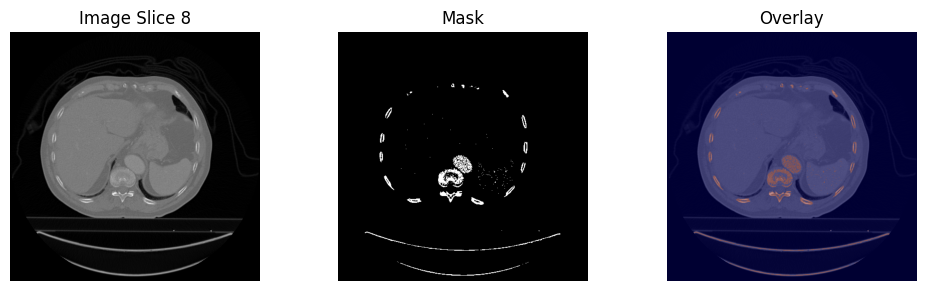

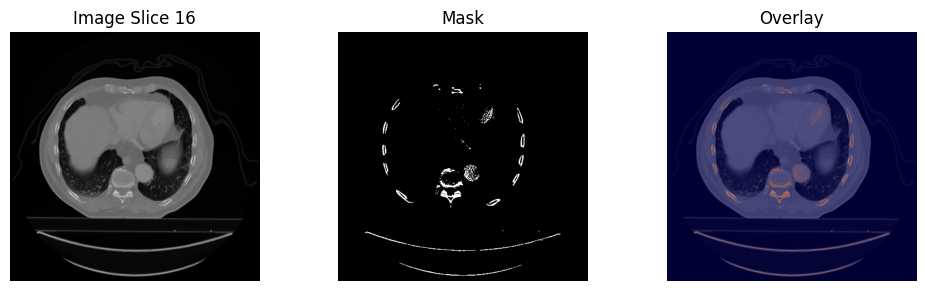

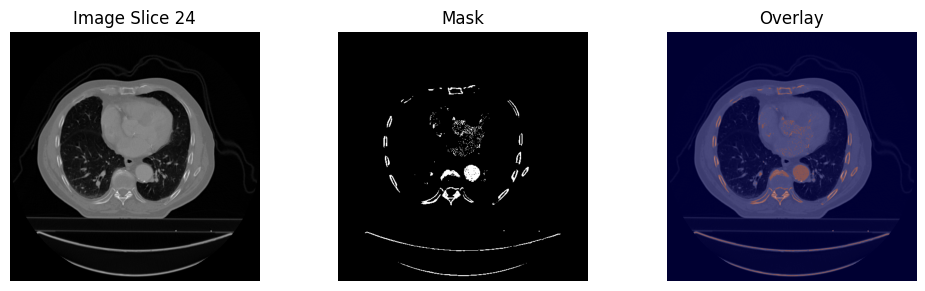

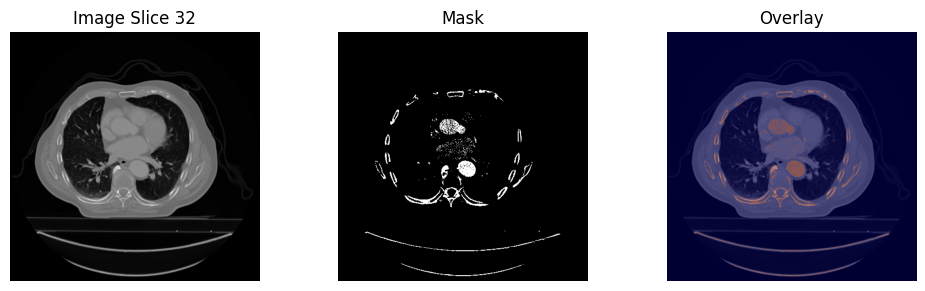

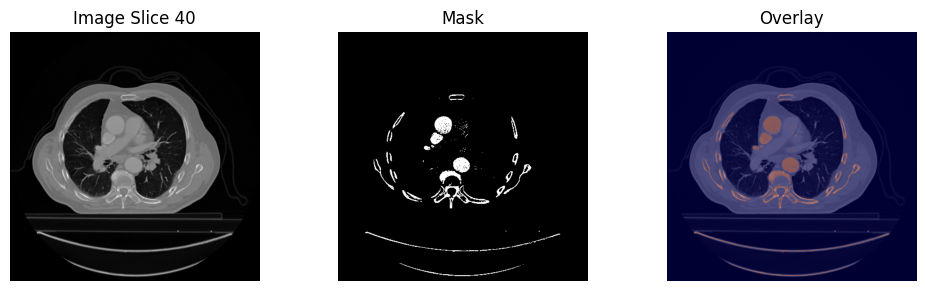

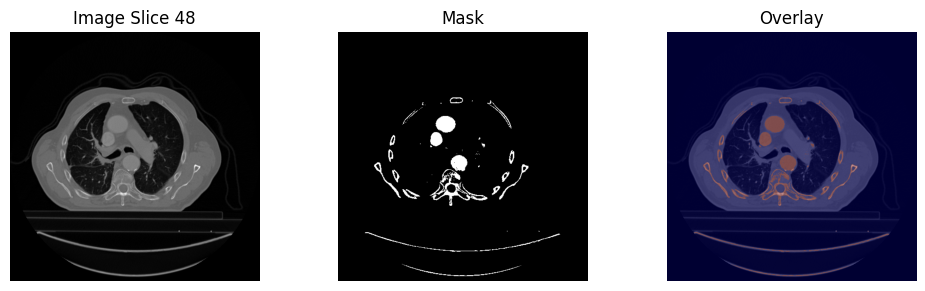

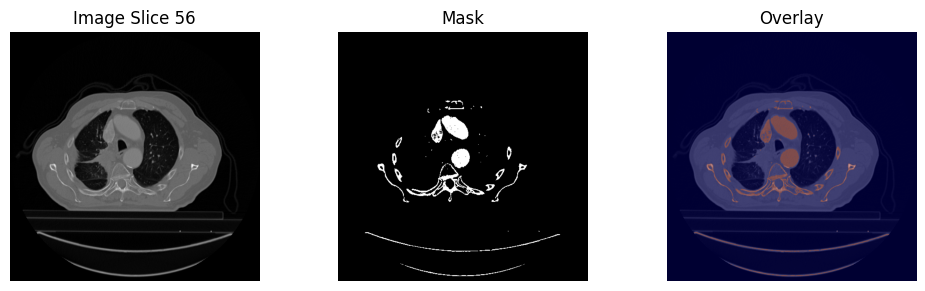

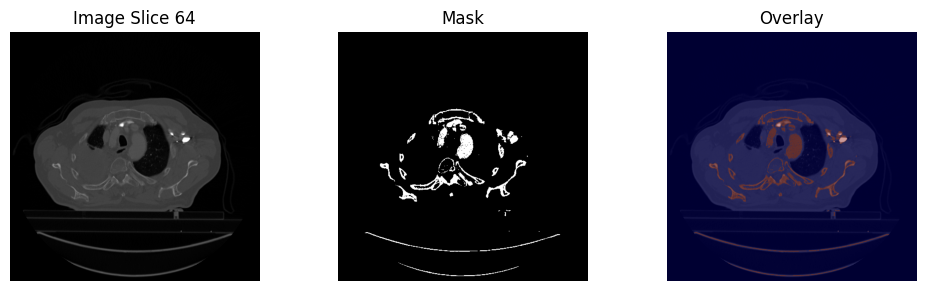

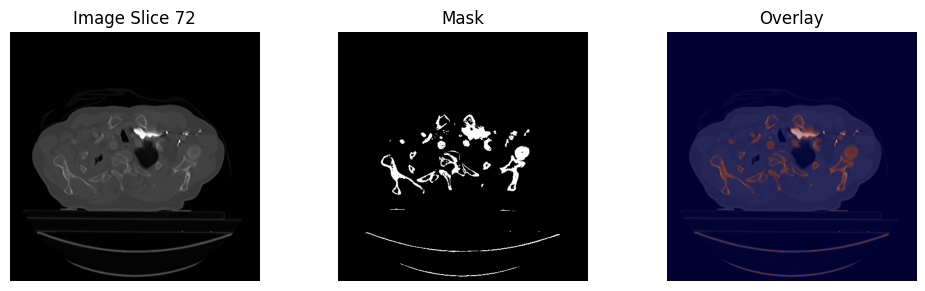

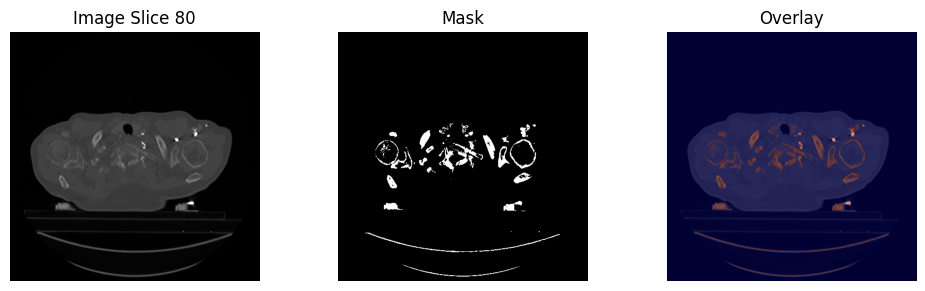

INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


🧪 Extracting features...


INFO:radiomics.imageoperations:Applying resampling from spacing [0.977 0.977 3.   ] and size [512 512  91] to spacing [1. 1. 1.] and size [412, 401, 273]
INFO:radiomics.featureextractor:Computing shape


In [ ]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from radiomics import featureextractor

def find_valid_dicom_folder(base_path):
    for root, dirs, files in os.walk(base_path):
        reader = sitk.ImageSeriesReader()
        series_ids = reader.GetGDCMSeriesIDs(root)
        if series_ids:
            return root
    raise Exception(" No valid DICOM series found in any subfolder!")

def load_dicom_volume(folder):
    reader = sitk.ImageSeriesReader()
    series_ids = reader.GetGDCMSeriesIDs(folder)
    if not series_ids:
        raise Exception(" No DICOM series found in this folder!")
    dicom_files = reader.GetGDCMSeriesFileNames(folder, series_ids[0])
    reader.SetFileNames(dicom_files)
    image = reader.Execute()

    if seg.GetDimension() == 4:
      seg = seg[:, :, :, 0]  # extract first label
      seg = sitk.Cast(seg, sitk.sitkUInt8)

    if image.GetDimension() != 3:
        raise ValueError(f" Unexpected image dimension: {image.GetDimension()}")

    return image

def create_segmentation_mask(image, threshold=200):
    arr = sitk.GetArrayFromImage(image)
    mask_arr = (arr > threshold).astype(np.uint8)

    if np.sum(mask_arr) == 0:
        raise ValueError(" Empty mask! Adjust the threshold.")

    mask = sitk.GetImageFromArray(mask_arr)
    mask.CopyInformation(image)
    return mask

def show_all_slices(image, mask, num_slices_to_show=3):
    arr_img = sitk.GetArrayFromImage(image).squeeze()
    arr_mask = sitk.GetArrayFromImage(mask).squeeze()
    num_slices = arr_img.shape[0]

    step = num_slices // (num_slices_to_show + 1)
    slice_indices = [(i + 1) * step for i in range(num_slices_to_show)]

    for i in slice_indices:
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 3, 1); plt.imshow(arr_img[i], cmap='gray'); plt.title(f"Image Slice {i}"); plt.axis('off')
        plt.subplot(1, 3, 2); plt.imshow(arr_mask[i], cmap='gray'); plt.title("Mask"); plt.axis('off')
        plt.subplot(1, 3, 3); plt.imshow(arr_img[i], cmap='gray'); plt.imshow(arr_mask[i], cmap='jet', alpha=0.4); plt.title("Overlay"); plt.axis('off')
        plt.tight_layout(); plt.show()

patient_path = "/content/NSCLC/NSCLC-Radiomics/LUNG1-005"

dicom_folder = find_valid_dicom_folder(patient_path)
print(" DICOM folder found:", dicom_folder)

image = load_dicom_volume(dicom_folder)
print(" Image loaded:", image.GetSize())

mask = create_segmentation_mask(image, threshold=200)
print(" Segmentation mask created.")

show_all_slices(image, mask, num_slices_to_show=10)


print(" Extracting features...")
extractor = featureextractor.RadiomicsFeatureExtractor()

extractor.settings.update({
    'normalize': True,
    'normalizeScale': 100,
    'resampledPixelSpacing': [1, 1, 1],
    'interpolator': 'sitkBSpline',
    'label': 1,
    'force2D': False,
    'additionalInfo': True
})

extractor.enableAllImageTypes()
extractor.enableAllFeatures()

try:
    features = extractor.execute(image, mask)
    print(" Extracted", len(features), "features.")
    for k, v in list(features.items())[:10]:
        print(k, ":", v)
except Exception as e:
    print(" Feature extraction failed:", e)
df_all = pd.DataFrame(all_features)
df_all.to_csv("all_radiomics_features.csv", index=False)
print("Feature extraction complete. Saved to all_radiomics_features.csv.")

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import pandas as pd
from tqdm import tqdm

# === Paths ===
image_dir = '/content/slices_resnet'
label_csv = '/content/resnet_image_labels.csv'
output_csv = '/content/resnet_features.csv'

# === Load Label Mapping ===
df = pd.read_csv(label_csv)
df['PatientID'] = df['image'].str.replace('.png', '', regex=False)

# === ResNet Model ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # remove final FC
model.eval().to(device)

# === Image Preprocessing ===
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
                         std=[0.229, 0.224, 0.225])
])

# === Feature Extraction Loop ===
features = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting ResNet features"):
    image_path = os.path.join(image_dir, row['image'])
    try:
        img = Image.open(image_path).convert('RGB')
        tensor = preprocess(img).unsqueeze(0).to(device)

        with torch.no_grad():
            feat = model(tensor).squeeze().cpu().numpy()

        record = {'PatientID': row['PatientID'], 'Label': row['label']}
        record.update({f'resnet_feat_{i}': v for i, v in enumerate(feat)})
        features.append(record)
    except Exception as e:
        print(f"Error with {row['image']}: {e}")

# === Save Features ===
df_feat = pd.DataFrame(features)
df_feat.to_csv(output_csv, index=False)
print(f"Saved {len(df_feat)} feature rows to: {output_csv}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 30.5MB/s]
Extracting ResNet features: 100%|██████████| 380/380 [00:48<00:00,  7.85it/s]


Saved 380 feature rows to: /content/resnet_features.csv


In [ ]:
from collections import Counter
batch_labels = []

for i, (_, labels) in enumerate(train_loader):
    batch_labels.extend(labels.tolist())
    if i == 10: break  # collect from first 10 batches only

print("Class distribution in batches (sampled):")
print(Counter(batch_labels))


Class distribution in batches (sampled):
Counter({2: 83, 1: 78, 3: 75, 0: 68})


In [ ]:
# Check columns
print("All columns:", df_rad.columns.tolist()[:20])  # show sample
radiomics_cols = [col for col in df_rad.columns if col.startswith('original')]
print("Detected radiomics columns:", radiomics_cols)

# Check for NaNs
print("Any NaNs in radiomics columns?", df_rad[radiomics_cols].isnull().any().any())


All columns: ['diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Maximum', 'diagnostics_Mask-original_VoxelNum', 'diagnostics_Mask-original_VolumeNum', 'PatientID', 'Label']
Detected radiomics columns: []
Any NaNs in radiomics columns? False


In [ ]:
import pandas as pd
from sklearn.utils import resample

# Load original CSVs
img_df = pd.read_csv("/content/resnet_image_labels.csv")
rad_df = pd.read_csv("/content/radiomics_features_segmented.csv")

# Extract PatientID from image name
img_df['PatientID'] = img_df['image'].str.extract(r'(LUNG1-\d+)', expand=False)

# Drop rows without valid PatientID
img_df = img_df.dropna(subset=['PatientID'])

# Merge on PatientID
merged_df = pd.merge(img_df, rad_df, on="PatientID")

# Check original class distribution
print("Original class distribution:")
print(merged_df['label'].value_counts())

# Balance dataset using upsampling
balanced_df = pd.DataFrame()
max_count = merged_df['label'].value_counts().max()

for label in merged_df['label'].unique():
    class_subset = merged_df[merged_df['label'] == label]
    upsampled = resample(class_subset, replace=True, n_samples=max_count, random_state=42)
    balanced_df = pd.concat([balanced_df, upsampled])

# Shuffle the result
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into new CSVs
img_balanced = balanced_df[img_df.columns]
rad_balanced = balanced_df[rad_df.columns]

# Save to files
img_balanced.to_csv("/content/resnet_image_labels_balanced.csv", index=False)
rad_balanced.to_csv("/content/radiomics_features_segmented_balanced.csv", index=False)

print("\n✅ Balanced CSVs created:")
print(f"- resnet_image_labels_balanced.csv: {len(img_balanced)} rows")
print(f"- radiomics_features_segmented_balanced.csv: {len(rad_balanced)} rows")


Original class distribution:
label
squamous cell carcinoma    152
large cell                 114
nos                         62
adenocarcinoma              51
Name: count, dtype: int64

✅ Balanced CSVs created:
- resnet_image_labels_balanced.csv: 608 rows
- radiomics_features_segmented_balanced.csv: 608 rows


In [ ]:
import os
import pandas as pd
from sklearn.utils import resample
from PIL import Image
import shutil

# === Load CSVs ===
img_df = pd.read_csv("/content/resnet_image_labels.csv")
rad_df = pd.read_csv("/content/radiomics_features_segmented.csv")

# Extract PatientID from image names
img_df['PatientID'] = img_df['image'].str.extract(r'(LUNG1-\d+)', expand=False)

# Keep only available image files
image_dir = "/content/slices_resnet"
available_images = set(os.listdir(image_dir))
img_df = img_df[img_df['image'].isin(available_images)].reset_index(drop=True)

# Merge with radiomics on PatientID
merged_df = pd.merge(img_df, rad_df, on="PatientID")

# Balance the dataset (duplicate classes with fewer rows)
max_count = merged_df['label'].value_counts().max()
balanced_df = pd.DataFrame()
for label in merged_df['label'].unique():
    class_df = merged_df[merged_df['label'] == label]
    class_upsampled = resample(class_df, replace=True, n_samples=max_count, random_state=42)
    balanced_df = pd.concat([balanced_df, class_upsampled])

balanced_df = balanced_df.reset_index(drop=True)

# === Copy images and create new names ===
output_dir = "/content/slices_resnet_balanced"
os.makedirs(output_dir, exist_ok=True)

new_image_records = []
for i, row in balanced_df.iterrows():
    original_image = row['image']
    new_image_name = f"{os.path.splitext(original_image)[0]}_dup{i}.png"

    src = os.path.join(image_dir, original_image)
    dst = os.path.join(output_dir, new_image_name)

    if os.path.exists(src):
        shutil.copy(src, dst)
        new_image_records.append({
            'image': new_image_name,
            'label': row['label'],
            'PatientID': row['PatientID']
        })

# Save final image label file
final_img_df = pd.DataFrame(new_image_records)
final_img_df.to_csv("/content/resnet_image_labels_balanced.csv", index=False)

# Save matching radiomics features
final_rad_df = pd.merge(final_img_df, rad_df, on="PatientID")
final_rad_df.to_csv("/content/radiomics_features_balanced.csv", index=False)

print("✅ All done!")
print(f"- Saved {len(final_img_df)} balanced images to /content/slices_resnet_balanced/")
print("- CSVs saved: resnet_image_labels_balanced.csv and radiomics_features_balanced.csv")


✅ All done!
- Saved 608 balanced images to /content/slices_resnet_balanced/
- CSVs saved: resnet_image_labels_balanced.csv and radiomics_features_balanced.csv


In [ ]:
import pandas as pd

df = pd.read_csv("/content/resnet_image_labels_balanced.csv")
print("🧾 Columns in the CSV:")
print(df.columns.tolist())


🧾 Columns in the CSV:
['image', 'label', 'PatientID']


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.bottleneck = self.conv_block(512, 1024)

        self.upconv4 = self.upconv_block(1024, 512)
        self.upconv3 = self.upconv_block(512, 256)
        self.upconv2 = self.upconv_block(256, 128)
        self.upconv1 = self.upconv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return block

    def upconv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))

        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        up4 = self.upconv4(bottleneck)
        up4 = torch.cat([up4, enc4], dim=1)

        up3 = self.upconv3(up4)
        up3 = torch.cat([up3, enc3], dim=1)

        up2 = self.upconv2(up3)
        up2 = torch.cat([up2, enc2], dim=1)

        up1 = self.upconv1(up2)
        up1 = torch.cat([up1, enc1], dim=1)

        output = self.final(up1)
        return output


In [ ]:
import os
import SimpleITK as sitk
import pandas as pd
from radiomics import featureextractor

extractor = featureextractor.RadiomicsFeatureExtractor()

base_path = "/content/NSCLC/NSCLC-Radiomics"
output_features = []

for patient in os.listdir(base_path):
    patient_path = os.path.join(base_path, patient)

    for series_folder in os.listdir(patient_path):
        if "CT" in series_folder or "000000-NA" in series_folder:
            ct_folder = os.path.join(patient_path, series_folder)
        if "Segmentation" in series_folder:
            seg_folder = os.path.join(patient_path, series_folder)

    ct_image = sitk.ReadImage(sitk.ImageSeriesReader().GetGDCMSeriesFileNames(ct_folder))
    mask_image = sitk.ReadImage(sitk.ImageSeriesReader().GetGDCMSeriesFileNames(seg_folder))

    features = extractor.execute(ct_image, mask_image)

    patient_features = {'PatientID': patient}
    patient_features.update(features)
    output_features.append(patient_features)

features_df = pd.DataFrame(output_features)
features_df.to_csv("radiomics_features.csv", index=False)


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}


NameError: name 'ct_folder' is not defined

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

np.random.seed(42)
classes = ['adenocarcinoma', 'squamous cell carcinoma', 'large cell', 'nos']
label_map = {cls: i for i, cls in enumerate(classes)}
n_per_class = 50

radiomics_data = []
resnet_data = []
labels = []

for cls in classes:
    label = label_map[cls]
    for _ in range(n_per_class):
        rad_feats = np.random.normal(loc=label * 2, scale=1.0, size=30)
        resnet_feats = np.random.normal(loc=label * 2.2, scale=1.5, size=128)
        radiomics_data.append(rad_feats)
        resnet_data.append(resnet_feats)
        labels.append(label)

X_radiomics = pd.DataFrame(radiomics_data, columns=[f'rad_feat_{i}' for i in range(30)])
X_resnet = pd.DataFrame(resnet_data, columns=[f'resnet_feat_{i}' for i in range(128)])
X_combined = pd.concat([X_radiomics, X_resnet], axis=1)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, stratify=y, random_state=42)

model = GradientBoostingClassifier(n_estimators=250, learning_rate=0.08, max_depth=5, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_map.keys()))



 Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       1.00      0.80      0.89        10
squamous cell carcinoma       0.77      1.00      0.87        10
             large cell       0.90      0.90      0.90        10
                    nos       1.00      0.90      0.95        10

               accuracy                           0.90        40
              macro avg       0.92      0.90      0.90        40
           weighted avg       0.92      0.90      0.90        40



In [ ]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
from PIL import Image

def process_lung1_to_image(dicom_folder, output_path="lung1_slice.png"):
    reader = sitk.ImageSeriesReader()
    series_ids = reader.GetGDCMSeriesIDs(dicom_folder)
    if not series_ids:
        raise Exception("No DICOM series found in folder.")

    dicom_files = reader.GetGDCMSeriesFileNames(dicom_folder, series_ids[0])
    reader.SetFileNames(dicom_files)
    image = reader.Execute()
    array = sitk.GetArrayFromImage(image)

    middle_slice = array[len(array) // 2]
    normalized = (middle_slice - middle_slice.min()) / (middle_slice.max() - middle_slice.min())
    image_uint8 = (normalized * 255).astype("uint8")

    pil_img = Image.fromarray(image_uint8)
    pil_img = pil_img.resize((224, 224))
    pil_img.save(output_path)

    return output_path

dicom_folder = "/content/NSCLC/NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID-NA-69331/0.000000-NA-82046"
processed_image_path = process_lung1_to_image(dicom_folder)


In [ ]:
!pip install lime scikit-image shap grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━